In [1]:
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import os
import csv
import re

# 1. Visualize what images and masks look like

In [2]:
def display_dicom_and_mask(dicom_file_path, mask_file_path):
    # read the DICOM file
    dicom_data = pydicom.dcmread(dicom_file_path)

    # get pixel data
    dicom_pixel_array = dicom_data.pixel_array

    # read the mask file
    mask_pixel_array = plt.imread(mask_file_path)

    # display the images side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(dicom_pixel_array, cmap=plt.cm.gray)
    axs[0].set_title('DICOM Image')

    axs[1].imshow(mask_pixel_array, cmap=plt.cm.gray)
    axs[1].set_title('Mask Image')

    plt.show()

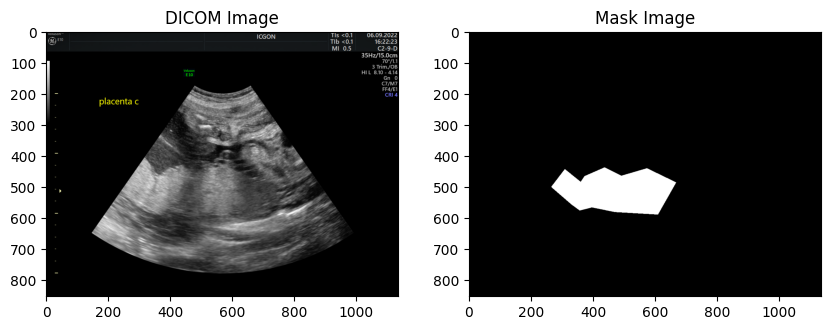

In [3]:
dicom_file_path = '../MASC/MASCARA PLACENTA 1-50/E75533-22-09-06-2_E CIR_PE 4_PLACENTA/20220906_162101/IMG_20220906_2_1.dcm'
mask_file_path = '../MASC/MASCARA PLACENTA 1-50/E75533-22-09-06-2_E CIR_PE 4_PLACENTA/20220906_162101/IMG_20220906_2_1_mask_P.png'
display_dicom_and_mask(dicom_file_path, mask_file_path)

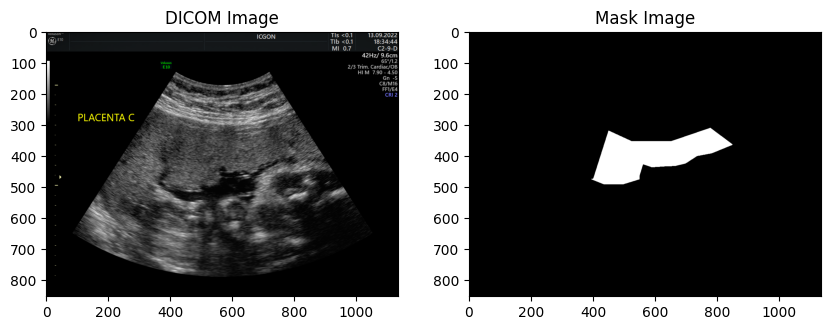

In [4]:
dicom_file_path = '../MASC/MASCARA PLACENTA 1-50/E75533-22-09-13-8_E CIR PE 14_PLACENTA/20220913_183355/IMG_20220913_1_1.dcm'
mask_file_path = '../MASC/MASCARA PLACENTA 1-50/E75533-22-09-13-8_E CIR PE 14_PLACENTA/20220913_183355/IMG_20220913_1_1_mask_A.png'
display_dicom_and_mask(dicom_file_path, mask_file_path)

# 2. Conditions counts

First, create a separate dataset that contains a list of images with a patient number assigned to them. This will be used to match patient records to corresponding images.

In [5]:
def create_csv_with_dcm_names(directory, output_csv):
    dcm_files = [filename for filename in os.listdir(directory) if filename.endswith('.dcm')]

    with open(output_csv, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['image_name'])
        for dcm_file in dcm_files:
            csv_writer.writerow([dcm_file])

create_csv_with_dcm_names('../MASC_processed', 'images_list.csv')

In [6]:
data = pd.read_csv('images_list.csv')

In [7]:
def extract_patient_number(filename):
    match = re.search(r'Patient_(\d+)', filename)
    patient_number = match.group(1)
    return patient_number

data['Patient_ID'] = data['image_name'].apply(extract_patient_number)

In [8]:
data['Patient_ID'] = data['Patient_ID'].astype(int)

## 2.1. Three criteria

Count how many healthy and unhealthy patients there are if we consider Insuficciency = Preeclampsia + CIR + low birth weight

In [9]:
bbdd = pd.read_csv('../../PLA_BBD.csv')
bbdd.head()

,Record ID,Origen étnico,Otra étnia,FECHA NACIMIENTO,FUR POR ECO,Edad materna,TPAL (sin guiones/puntos),Nuliparidad,Periodo intergenésico MENOR a 6 meses,Técnica de reproducción asistida (en gestación actual),...,"Hiperbilirrubinemia, µmol/l (nivel máximo) *250 µmol/L = 14.62 mg/dL *340 µmol/L = 19.88 mg/dL",Puntuación 22,Cultivo bacteriano,Puntuación 23,Hemorragia intraventricular,Puntuación 24,RCP durante el ingreso,Puntuación 25,Calculo MAIN (morbidity assessment index for newborns),Complete?.9
0,1,Europa,NaN,1988-08-10,2022-02-20,33,1041,No,No,No,...,No hiperbilirrubinemia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete
1,2,Europa,NaN,1986-05-14,2022-02-22,35,1011,No,No,No,...,No hiperbilirrubinemia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete
2,3,Europa,NaN,1997-10-26,2022-03-11,24,0,Yes,NaN,No,...,No hiperbilirrubinemia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete
3,4,Sudasia,NaN,1980-10-22,2022-03-01,41,3003,No,No,No,...,Bilirrubina sérica >250/fototerapia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete
4,5,Europa,NaN,1980-05-17,2022-02-28,41,0,Yes,NaN,Yes,...,No hiperbilirrubinemia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete


In [10]:
bbdd = bbdd[['Record ID','Preeclampsia','Diagnóstico de CIR (prenatal) ','Percentil peso nacimiento']]

In [11]:
bbdd['label_pos'] = bbdd.apply(lambda row: 1 if row['Preeclampsia'] == 'Yes' or row['Diagnóstico de CIR (prenatal) '] == 'Yes' or row['Percentil peso nacimiento'] < 10 else np.nan, axis=1)
bbdd['label_neg'] = bbdd.apply(lambda row: 0 if row['Preeclampsia'] == 'No' and row['Diagnóstico de CIR (prenatal) '] == 'No' and row['Percentil peso nacimiento'] >= 10 else np.nan, axis=1)
bbdd['label'] = np.where(bbdd['label_pos'].notna(), bbdd['label_pos'], np.where(bbdd['label_neg'].notna(), bbdd['label_neg'], np.nan))
bbdd = bbdd.dropna(subset=['label'])

In [12]:
labeled_data = data.merge(bbdd[['Record ID', 'label']], left_on='Patient_ID', right_on='Record ID', how='left')
labeled_data = labeled_data.dropna(subset=['label'])
labeled_data['label'] = labeled_data['label'].astype(int)

In [13]:
# total healthy patients and patients affected in full dataset
patients_labeled = labeled_data[['Patient_ID', 'label']].drop_duplicates()
label_counts = patients_labeled['label'].value_counts()

# counts for each label
patients_with_condition = label_counts.get(1, 0)
patients_without_condition = label_counts.get(0, 0)
total_patients = patients_with_condition + patients_without_condition
total_images_with_condition = labeled_data[labeled_data['label'] == 1]['image_name'].nunique()
total_images_without_condition = labeled_data[labeled_data['label'] == 0]['image_name'].nunique()
total_images = total_images_with_condition + total_images_without_condition

# print results
print('THREE CRITERIA')
print('- - -')
print(f"Total patients with sufficient information: {total_patients}")
print(f"Total patients with the condition: {patients_with_condition}")
print(f"Total patients without the condition: {patients_without_condition}")
print('')
print(f"Total image-mask pairs available: {total_images}")
print(f"Total images with the condition: {total_images_with_condition}")
print(f"Total images without the condition: {total_images_without_condition}")

THREE CRITERIA
- - -
Total patients with sufficient information: 354
Total patients with the condition: 76
Total patients without the condition: 278

Total image-mask pairs available: 1064
Total images with the condition: 228
Total images without the condition: 836


## 2.2. Preeclampsia

In [14]:
bbdd = pd.read_csv('../../PLA_BBD.csv')
bbdd = bbdd[['Record ID','Preeclampsia']]

In [15]:
bbdd['label_pos'] = bbdd.apply(lambda row: 1 if row['Preeclampsia'] == 'Yes' else np.nan, axis=1)
bbdd['label_neg'] = bbdd.apply(lambda row: 0 if row['Preeclampsia'] == 'No' else np.nan, axis=1)
bbdd['label'] = np.where(bbdd['label_pos'].notna(), bbdd['label_pos'], np.where(bbdd['label_neg'].notna(), bbdd['label_neg'], np.nan))
bbdd = bbdd.dropna(subset=['label'])

In [16]:
labeled_data = data.merge(bbdd[['Record ID', 'label']], left_on='Patient_ID', right_on='Record ID', how='left')
labeled_data = labeled_data.dropna(subset=['label'])
labeled_data['label'] = labeled_data['label'].astype(int)

In [17]:
# total healthy patients and patients affected in full dataset
patients_labeled = labeled_data[['Patient_ID', 'label']].drop_duplicates()
label_counts = patients_labeled['label'].value_counts()

# counts for each label
patients_with_condition = label_counts.get(1, 0)
patients_without_condition = label_counts.get(0, 0)
total_patients = patients_with_condition + patients_without_condition
total_images_with_condition = labeled_data[labeled_data['label'] == 1]['image_name'].nunique()
total_images_without_condition = labeled_data[labeled_data['label'] == 0]['image_name'].nunique()
total_images = total_images_with_condition + total_images_without_condition

# print results
print('PREECLAMPSIA')
print('- - -')
print(f"Total patients with sufficient information: {total_patients}")
print(f"Total patients with the condition: {patients_with_condition}")
print(f"Total patients without the condition: {patients_without_condition}")
print('')
print(f"Total image-mask pairs available: {total_images}")
print(f"Total images with the condition: {total_images_with_condition}")
print(f"Total images without the condition: {total_images_without_condition}")

PREECLAMPSIA
- - -
Total patients with sufficient information: 357
Total patients with the condition: 22
Total patients without the condition: 335

Total image-mask pairs available: 1073
Total images with the condition: 66
Total images without the condition: 1007


## 2.3. CIR

In [18]:
bbdd = pd.read_csv('../../PLA_BBD.csv')
bbdd = bbdd[['Record ID','Diagnóstico de CIR (prenatal) ']]

In [19]:
bbdd['label_pos'] = bbdd.apply(lambda row: 1 if row['Diagnóstico de CIR (prenatal) '] == 'Yes' else np.nan, axis=1)
bbdd['label_neg'] = bbdd.apply(lambda row: 0 if row['Diagnóstico de CIR (prenatal) '] == 'No' else np.nan, axis=1)
bbdd['label'] = np.where(bbdd['label_pos'].notna(), bbdd['label_pos'], np.where(bbdd['label_neg'].notna(), bbdd['label_neg'], np.nan))
bbdd = bbdd.dropna(subset=['label'])

In [20]:
labeled_data = data.merge(bbdd[['Record ID', 'label']], left_on='Patient_ID', right_on='Record ID', how='left')
labeled_data = labeled_data.dropna(subset=['label'])
labeled_data['label'] = labeled_data['label'].astype(int)

In [21]:
# total healthy patients and patients affected in full dataset
patients_labeled = labeled_data[['Patient_ID', 'label']].drop_duplicates()
label_counts = patients_labeled['label'].value_counts()

# counts for each label
patients_with_condition = label_counts.get(1, 0)
patients_without_condition = label_counts.get(0, 0)
total_patients = patients_with_condition + patients_without_condition
total_images_with_condition = labeled_data[labeled_data['label'] == 1]['image_name'].nunique()
total_images_without_condition = labeled_data[labeled_data['label'] == 0]['image_name'].nunique()
total_images = total_images_with_condition + total_images_without_condition

# print results
print('CIR')
print('- - -')
print(f"Total patients with sufficient information: {total_patients}")
print(f"Total patients with the condition: {patients_with_condition}")
print(f"Total patients without the condition: {patients_without_condition}")
print('')
print(f"Total image-mask pairs available: {total_images}")
print(f"Total images with the condition: {total_images_with_condition}")
print(f"Total images without the condition: {total_images_without_condition}")

CIR
- - -
Total patients with sufficient information: 358
Total patients with the condition: 22
Total patients without the condition: 336

Total image-mask pairs available: 1076
Total images with the condition: 66
Total images without the condition: 1010


## 2.4. Low birth weight

In [22]:
bbdd = pd.read_csv('../../PLA_BBD.csv')
bbdd = bbdd[['Record ID','Percentil peso nacimiento']]

In [23]:
bbdd['label_pos'] = bbdd.apply(lambda row: 1 if row['Percentil peso nacimiento'] < 10 else np.nan, axis=1)
bbdd['label_neg'] = bbdd.apply(lambda row: 0 if row['Percentil peso nacimiento'] >= 10 else np.nan, axis=1)
bbdd['label'] = np.where(bbdd['label_pos'].notna(), bbdd['label_pos'], np.where(bbdd['label_neg'].notna(), bbdd['label_neg'], np.nan))
bbdd = bbdd.dropna(subset=['label'])

In [24]:
labeled_data = data.merge(bbdd[['Record ID', 'label']], left_on='Patient_ID', right_on='Record ID', how='left')
labeled_data = labeled_data.dropna(subset=['label'])
labeled_data['label'] = labeled_data['label'].astype(int)

In [25]:
# total healthy patients and patients affected in full dataset
patients_labeled = labeled_data[['Patient_ID', 'label']].drop_duplicates()
label_counts = patients_labeled['label'].value_counts()

# counts for each label
patients_with_condition = label_counts.get(1, 0)
patients_without_condition = label_counts.get(0, 0)
total_patients = patients_with_condition + patients_without_condition
total_images_with_condition = labeled_data[labeled_data['label'] == 1]['image_name'].nunique()
total_images_without_condition = labeled_data[labeled_data['label'] == 0]['image_name'].nunique()
total_images = total_images_with_condition + total_images_without_condition

# print results
print('LOW BIRTH WEIGHT')
print('- - -')
print(f"Total patients with sufficient information: {total_patients}")
print(f"Total patients with the condition: {patients_with_condition}")
print(f"Total patients without the condition: {patients_without_condition}")
print('')
print(f"Total image-mask pairs available: {total_images}")
print(f"Total images with the condition: {total_images_with_condition}")
print(f"Total images without the condition: {total_images_without_condition}")

LOW BIRTH WEIGHT
- - -
Total patients with sufficient information: 353
Total patients with the condition: 57
Total patients without the condition: 296

Total image-mask pairs available: 1061
Total images with the condition: 171
Total images without the condition: 890
